## Prerequisite

In [1]:
!pip install kaggle

In [2]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 70% 57.0M/80.9M [00:00<00:00, 202MB/s]
100% 80.9M/80.9M [00:00<00:00, 213MB/s]


In [4]:
# Extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 4.5 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Data Processing

**Columns:**

1. **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. **ids**: The id of the tweet (2087)

3. **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

5. **user**: the user that tweeted (robotickilldozr)

6. **text**: the text of the tweet (Lyx is cool)

In [9]:
dataset_columns = ["target", "ids", "date", "flag", "user", "text"]

In [10]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding =' ISO-8859-1', names = dataset_columns)

In [11]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [13]:
# Counting the number of missing values in the dataset
df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


The output shows that there are no missing values in any of the columns, which is great for analysis.

In [14]:
# Checking the distribution of target columns
df['target'].value_counts()

,count
target,
0,800000
4,800000


In [15]:
df.replace({'target':{4:1}}, inplace = True)

- A target of `0` represents a **negative** tweet.
- A target of `1` represents a **positive** tweet.

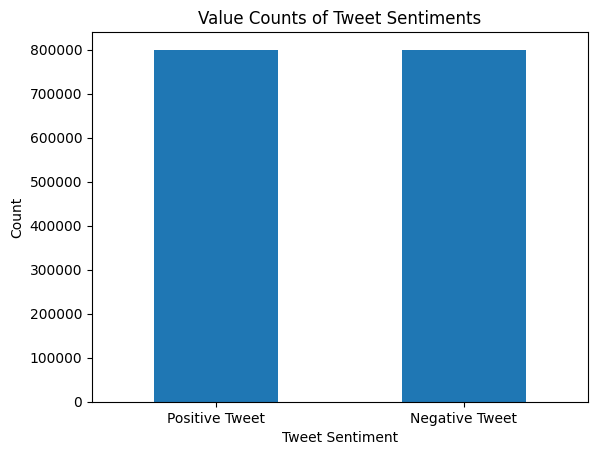

In [16]:
# Plot the value counts
ax = df['target'].value_counts().plot(kind='bar')

# Set custom tick labels
ax.set_xticklabels(['Positive Tweet', 'Negative Tweet'], rotation=0)

# Add labels and title
plt.xlabel('Tweet Sentiment')
plt.ylabel('Count')
plt.title('Value Counts of Tweet Sentiments')
plt.show()

## Stemming and Wordcloud

In [17]:
stop_words = stopwords.words("english")
port_stemmer = PorterStemmer()
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [18]:
def preprocess(text, stem = False):
    # Remove link, user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

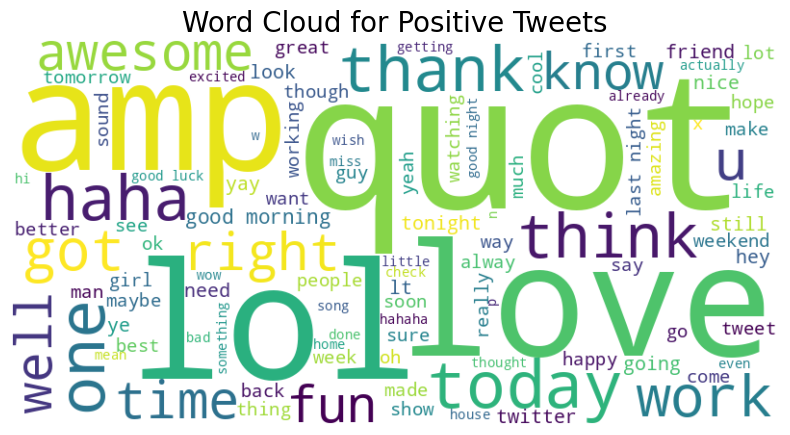

In [19]:
# Separate positive tweets
positive_tweets = df[df['target'] == 1]['text']

# Preprocess the positive tweets
positive_tweets_cleaned = " ".join(positive_tweets.apply(lambda x: preprocess(x, stem=False)))

# Generate and plot the word cloud for positive tweets
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for positive tweets
plot_wordcloud(positive_tweets_cleaned, "Word Cloud for Positive Tweets")

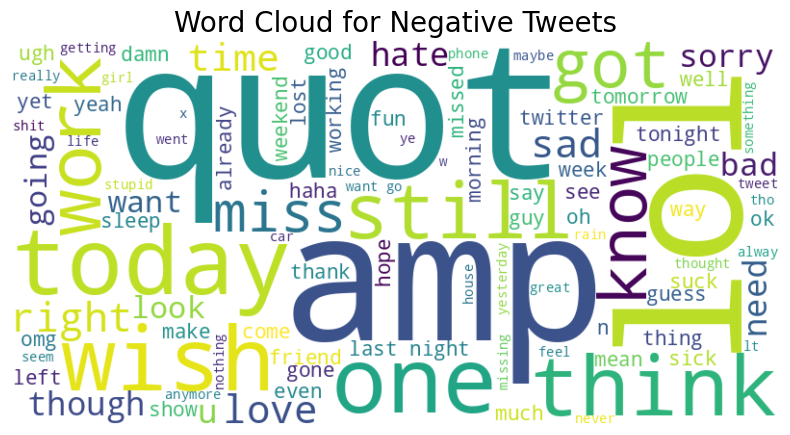

In [20]:
# Separate negative tweets
negative_tweets = df[df['target'] == 0]['text']

# Preprocess the negative tweets
negative_tweets_cleaned = " ".join(negative_tweets.apply(lambda x: preprocess(x, stem=False)))

# Generate and plot the word cloud for negative tweets
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for negative tweets
plot_wordcloud(negative_tweets_cleaned, "Word Cloud for Negative Tweets")

In [21]:
df['stemmed_content'] = df['text'].apply(preprocess)

In [22]:
df.head()

,target,ids,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [23]:
print(df['stemmed_content'])

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: stemmed_content, Length: 1600000, dtype: object


In [24]:
print(df['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [25]:
# Separating the data and label
X = df['stemmed_content'].values
y = df['target'].values

In [26]:
print(X)

['awww bummer shoulda got david carr third day'
 'upset update facebook texting might cry result school today also blah'
 'dived many times ball managed save 50 rest go bounds' ...
 'ready mojo makeover ask details'
 'happy 38th birthday boo alll time tupac amaru shakur'
 'happy charitytuesday thenspcc sparkscharity speakinguph4h']


In [27]:
print(y)

[0 0 0 ... 1 1 1]


## Splitting the Data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2)

In [29]:
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1280000
TEST size: 320000


In [30]:
# Converting the textual data to numerical data
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [31]:
print(X_train)

  (0, 275839)	0.31944928864833405
  (0, 221668)	0.3452365676331252
  (0, 128479)	0.5133275369633379
  (0, 76521)	0.4028542458897644
  (0, 150166)	0.40629665547401433
  (0, 280571)	0.4334630185671485
  (2, 76521)	0.48128850025492076
  (2, 85599)	0.18366319747759238
  (2, 255130)	0.17579241905853688
  (2, 89700)	0.27633648256788446
  (2, 254662)	0.31578763334534543
  (2, 273357)	0.31058399174652385
  (2, 56265)	0.29554366234223683
  (2, 280833)	0.3898586978106588
  (2, 166847)	0.229912733513344
  (2, 256368)	0.1470117211584014
  (2, 123327)	0.1533581626521967
  (2, 104648)	0.17667875368732683
  (2, 91846)	0.1942908972527937
  (2, 178784)	0.15776217957576424
  (3, 254662)	0.28617375135973083
  (3, 110794)	0.4836950796326333
  (3, 105520)	0.26284185656975323
  (3, 43393)	0.4899700016399023
  (3, 244699)	0.3726900824740739
  :	:
  (1279996, 198116)	0.22403186424931995
  (1279996, 273695)	0.27347710693644417
  (1279996, 245737)	0.2076875360138085
  (1279996, 233879)	0.41583152508740906
  (12

In [32]:
print(X_test)

  (0, 17039)	0.1797799861665213
  (0, 26494)	0.1700782103615806
  (0, 50289)	0.2928243363492343
  (0, 74507)	0.452728993409941
  (0, 91880)	0.2674303113452972
  (0, 96188)	0.24782966679820204
  (0, 119417)	0.294686709004799
  (0, 173018)	0.18627392884148614
  (0, 244461)	0.23057109441022683
  (0, 251398)	0.43490413383906834
  (0, 256368)	0.338726615565581
  (0, 264569)	0.19111729905948868
  (1, 13164)	0.5375757538742224
  (1, 17039)	0.184520696116258
  (1, 101321)	0.5025922488779689
  (1, 141052)	0.360807908114163
  (1, 161661)	0.2516604423610024
  (1, 218331)	0.42483418109419807
  (1, 229145)	0.22442381042591564
  (2, 20846)	0.43833540505980706
  (2, 29136)	0.4668687679266717
  (2, 65157)	0.44635712373737735
  (2, 161701)	0.3156896439352119
  (2, 252520)	0.5394450787676547
  (3, 82728)	0.6772236223440107
  :	:
  (319994, 255130)	0.21287125033834722
  (319994, 276234)	0.21273053309716664
  (319994, 281117)	0.2620725423705306
  (319995, 75660)	0.3419038819771878
  (319995, 76618)	0.3244

## Training ML Models

### Logistic Regression

In [33]:
model = LogisticRegression(max_iter = 1000)

In [34]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [35]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train)

In [36]:
print('Accuracy score on the training data: ', training_data_accuracy)

Accuracy score on the training data:  0.79650625


In [37]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)

In [38]:
print('Accuracy score on the test data: ', test_data_accuracy)

Accuracy score on the test data:  0.780171875


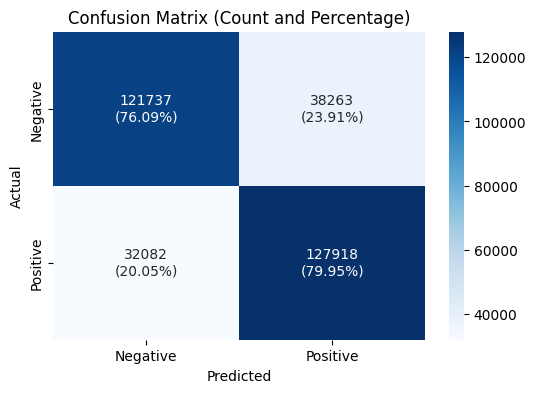

In [39]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, X_test_prediction)

# Calculate percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create annotations for counts and percentages
annotations = []
for i in range(len(conf_matrix)):
    row = []
    for j in range(len(conf_matrix[i])):
        count = conf_matrix[i][j]
        percentage = conf_matrix_percentage[i][j]
        row.append(f"{count}\n({percentage:.2f}%)")
    annotations.append(row)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Count and Percentage)')
plt.show()

In [40]:
# Generating the classification report
print("Classification Report:")
print(classification_report(y_test, X_test_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes model
naive_bayes_model = MultinomialNB()

# Fit the model on the training data
naive_bayes_model.fit(X_train, y_train)

# Predict on the training data
X_train_prediction_nb = naive_bayes_model.predict(X_train)
training_data_accuracy_nb = accuracy_score(X_train_prediction_nb, y_train)
print('Accuracy score on the training data (Naive Bayes): ', training_data_accuracy_nb)

# Predict on the test data
X_test_prediction_nb = naive_bayes_model.predict(X_test)
test_data_accuracy_nb = accuracy_score(X_test_prediction_nb, y_test)
print('Accuracy score on the test data (Naive Bayes): ', test_data_accuracy_nb)

Accuracy score on the training data (Naive Bayes):  0.79950390625
Accuracy score on the test data (Naive Bayes):  0.763034375


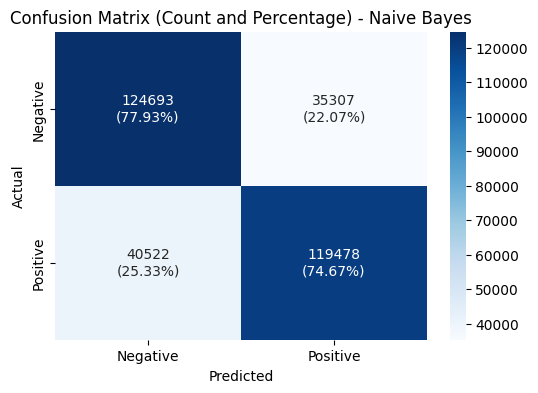

In [42]:
# Generating the confusion matrix
conf_matrix_nb = confusion_matrix(y_test, X_test_prediction_nb)

# Calculate percentages
conf_matrix_percentage_nb = conf_matrix_nb.astype('float') / conf_matrix_nb.sum(axis=1)[:, np.newaxis] * 100

# Create annotations for counts and percentages
annotations_nb = []
for i in range(len(conf_matrix_nb)):
    row = []
    for j in range(len(conf_matrix_nb[i])):
        count = conf_matrix_nb[i][j]
        percentage = conf_matrix_percentage_nb[i][j]
        row.append(f"{count}\n({percentage:.2f}%)")
    annotations_nb.append(row)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=annotations_nb, fmt='', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Count and Percentage) - Naive Bayes')
plt.show()

In [43]:
# Generating the classification report
print("Classification Report (Naive Bayes):")
print(classification_report(y_test, X_test_prediction_nb))

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.75      0.78      0.77    160000
           1       0.77      0.75      0.76    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



Based on the result of both the **Logistic Regression** and **Naive Bayes** models, the following observations can be made:

### 1. **Accuracy Comparison**:
   - **Logistic Regression**:
     - Training accuracy: 79.65%
     - Test accuracy: 78.02%
   - **Naive Bayes**:
     - Training accuracy: 79.95%
     - Test accuracy: 76.30%
   - While the Naive Bayes model performs slightly better on the training set (by ~0.30%), the Logistic Regression model generalizes better to the test set, maintaining a higher test accuracy (78.02% vs. 76.30%). This suggests that Naive Bayes may be overfitting slightly compared to Logistic Regression.

### 2. **Precision, Recall, and F1-Score**:
   - **Logistic Regression**:
     - For class `0` (Negative): Precision is 0.79, and recall is 0.76, which gives a balanced F1-score of 0.78.
     - For class `1` (Positive): Precision is 0.77, and recall is 0.80, resulting in an F1-score of 0.78.
   - **Naive Bayes**:
     - For class `0` (Negative): Precision is slightly lower at 0.75, and recall is higher at 0.78, giving an F1-score of 0.77.
     - For class `1` (Positive): Precision is 0.77, and recall is lower at 0.75, resulting in a slightly lower F1-score of 0.76.
   - **Observation**: Logistic Regression shows a more balanced performance across precision, recall, and F1-score for both classes, while Naive Bayes shows a slight imbalance, particularly in recall for class `1` (Positive).

### 3. **General Performance**:
   - Logistic Regression exhibits better overall performance on both the training and test datasets, with higher precision, recall, and F1-scores compared to Naive Bayes.
   - Naive Bayes, while performing slightly better on the training data, falls short on the test data, indicating that Logistic Regression is more robust in this case, especially in terms of its ability to generalize.

### Conclusion:
 **Logistic Regression** performs better than **Naive Bayes** on the test dataset, making it a more reliable model for this sentiment analysis task. Naive Bayes might still be useful for quick, baseline modeling due to its simplicity but does not match the generalization performance of Logistic Regression in this case.

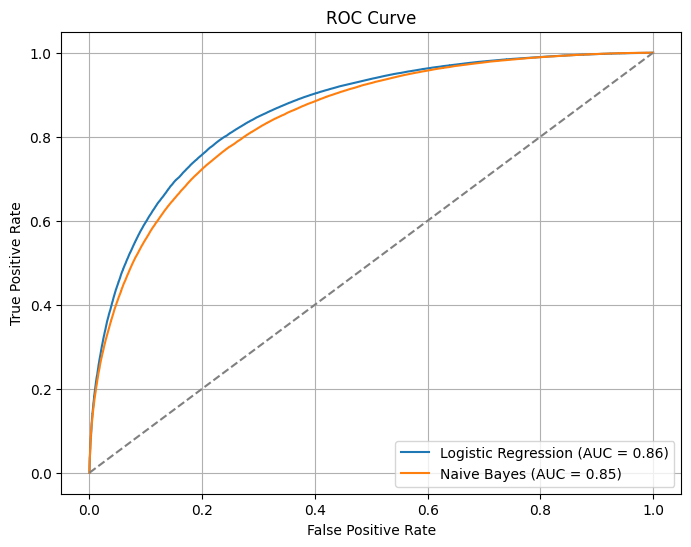

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression - Predict probabilities
logreg_probs = model.predict_proba(X_test)[:, 1]

# Naive Bayes - Predict probabilities
nb_probs = naive_bayes_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for Logistic Regression
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
logreg_auc = roc_auc_score(y_test, logreg_probs)

# Calculate ROC curve and AUC for Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(logreg_fpr, logreg_tpr, linestyle='-', label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, linestyle='-', label=f'Naive Bayes (AUC = {nb_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()

# Show the plot
plt.show()

## Saving the Trained Models

In [45]:
import pickle

In [46]:
# Save the Logistic Regression model
file_lr = open('Sentiment-LR.pickle', 'wb')
pickle.dump(model, file_lr)  # 'model' is our Logistic Regression model
file_lr.close()

# Save the Naive Bayes model
file_nb = open('Sentiment-NB.pickle', 'wb')
pickle.dump(naive_bayes_model, file_nb)  # 'naive_bayes_model' is our Naive Bayes model
file_nb.close()